In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# Load saved data
from google.colab import drive
drive.mount('/content/drive')
data = np.load('/content/drive/My Drive/Github/mtc-device-activation/data/activity-models/e2-general-model.npz', allow_pickle=True)
all_DeviceLocations = data['all_DeviceLocations']
num_samples = data['num_samples']
device_count = data['device_count']
sparsity = data['sparsity']

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-theta.npz", allow_pickle=True)
all_theta = data["all_theta"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-gamma.npz", allow_pickle=True)
all_gamma = data["all_gamma"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-z.npz", allow_pickle=True)
all_z = data["all_z"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-noise.npz", allow_pickle=True)
all_noise = data["all_noise"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-received-signal.npz", allow_pickle=True)
all_received_signal = data["all_received_signal"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-general.npz", allow_pickle=True)
snr_db_array = data["snr_db_array"]
pilot_length_array = data["pilot_length_array"]
M = data["M"]

pilot_length_index = 2
pilot_length=pilot_length_array[pilot_length_index]

Mounted at /content/drive


In [ ]:
num_samples = 1000
sample_range = range(200, 400)

Correlation-Aware Sparse Bayesian Learning (CA-SBL)

In [ ]:
def casbl_anc_algorithm(theta, y, noise_var, loc, alpha=1.00, beta=0.1, rho=7, U=20, max_iter=500, stopping_criterion=1e-4):
    """Correlation Aware Sparse Bayesian Learning (CASBL) for Multiple Measurement Vectors (MMV)."""

    M = y.shape[1]  # Number of antennas (columns of y)

    L = theta.shape[0]  # Pilot Length (rows of theta)
    N = theta.shape[1] # Number of MTDs (columns of theta)

    # Initialize Gamma (covariance matrix of the signal)
    Gamma = np.eye(N) * 0.1  # Initial guess

    if rho == 0:
        correlation_matrix = np.eye(N)  # Identity matrix when no correlation
    else:
        # Compute pairwise distances (N x N matrix)
        distance_matrix = np.linalg.norm(loc[:, np.newaxis, :] - loc[np.newaxis, :, :], axis=2)

        # Compute exponential decay matrix
        correlation_matrix = np.maximum((np.exp(-distance_matrix / rho) - np.exp(-U / rho)) / (1 - np.exp(-U / rho)),0)

    # Outer loop over the maximum number of iterations
    for t in range(max_iter):
        # E-Step: Compute the mean (mu_x) and covariance (Sigma_x) of x
        Sigma_y = theta @ Gamma @ theta.conj().T + noise_var * np.eye(L)
        Sigma_y_inv = np.linalg.inv(Sigma_y)
        Sigma_x = Gamma - Gamma @ theta.conj().T @ Sigma_y_inv @ theta @ Gamma
        mu_x = Gamma @ theta.conj().T @ Sigma_y_inv @ y

        # Compute Q
        Q = (np.linalg.norm(mu_x, axis=1) ** 2) / M + np.diag(Sigma_x)

        # Compute P
        P = 2 * alpha * (beta - correlation_matrix) @ np.diag(Gamma)
        P = np.maximum(P, 1e-8)

        # Compute gamma update
        gamma_new = (np.sqrt(1 + 4 * P * Q) - 1) / (2 * P)

        # Ensure non-negativity (numerical stability)
        gamma_new = np.clip(np.real(gamma_new), 0, 1)

        # Update Gamma
        Gamma_old = np.diag(Gamma)
        Gamma = np.diagflat(gamma_new)

        # Check for convergence
        if np.linalg.norm(Gamma_old - gamma_new) < stopping_criterion:
            print(f"Converged after {t+1} outer iterations")
            break

    Gamma = np.where(Gamma < 0.05, 0, 1)

    Sigma_y = theta @ Gamma @ theta.conj().T + noise_var * np.eye(L)
    Sigma_y_inv = np.linalg.inv(Sigma_y)
    Sigma_x = Gamma - Gamma @ theta.conj().T @ Sigma_y_inv @ theta @ Gamma
    mu_x = Gamma @ theta.conj().T @ Sigma_y_inv @ y

    return mu_x, np.diag(Gamma)  # Final estimates


In [ ]:
# Placeholder arrays for results
z_res = np.zeros((num_samples, len(snr_db_array), device_count, M), dtype=np.complex128)  # Z estimates
gamma_res = np.zeros((num_samples, len(snr_db_array), device_count), dtype=bool)  # Gamma support

hr_res = np.zeros((num_samples, len(snr_db_array)))         # HR
fr_res = np.zeros((num_samples, len(snr_db_array)))         # FR
srr_res = np.zeros((num_samples, len(snr_db_array)))        # SRR
precision_res = np.zeros((num_samples, len(snr_db_array)))  # Precision
recall_res = np.zeros((num_samples, len(snr_db_array)))     # Recall
f1_res = np.zeros((num_samples, len(snr_db_array)))         # F1
nmse_res = np.zeros((num_samples, len(snr_db_array)))       # NMSE

In [6]:
# Loop through each sample with an outer progress bar
for sample_index in tqdm(sample_range, desc="Processing Samples", position=0):
    theta = all_theta[sample_index, pilot_length_index, :pilot_length]
    gamma = all_gamma[sample_index]  # Ground truth gamma values (true support)
    loc = all_DeviceLocations[sample_index]

    # Loop over each SNR level with an inner progress bar
    for snr_db_index in tqdm(range(len(snr_db_array)), desc="Processing SNR Levels", leave=False, position=1):
        received_signal = all_received_signal[sample_index, pilot_length_index, snr_db_index, :pilot_length]
        z = all_z[sample_index]
        snr_db = snr_db_array[snr_db_index]
        snr = 10 ** (snr_db / 10)
        signal_power = np.mean(np.abs(np.matmul(theta, z))**2)
        noise_power = signal_power / snr

        # Apply SBL algorithm for the current sample and SNR level
        z_result, gamma_result = casbl_anc_algorithm(theta, received_signal, noise_power, loc)

        # Zero-out results with low gamma values
        z_result[gamma_result <= 0.05] = 0
        z_res[sample_index, snr_db_index, :, :] = z_result
        gamma_result_bool = gamma_result > 0.05
        gamma_res[sample_index, snr_db_index, :] = gamma_result_bool

        # Compute number of active/inactive devices from ground truth
        active_devices = np.sum(gamma == 1)
        inactive_devices = np.sum(gamma == 0)

        # Hit rate: percentage of correctly identified active devices
        hr_res[sample_index, snr_db_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 1)) / active_devices if active_devices > 0 else 0
        )

        # False alarm rate: percentage of inactive devices wrongly detected as active
        fr_res[sample_index, snr_db_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 0)) / inactive_devices if inactive_devices > 0 else 0
        )

        # Support recovery rate: proportion of correctly identified active devices
        srr_res[sample_index, snr_db_index] = (
            np.sum((gamma_result_bool == 1) & (gamma == 1)) /
            (np.sum((gamma_result_bool == 1) & (gamma == 0)) + np.sum((gamma_result_bool == 0) & (gamma == 1)) + sparsity)
        )

        # Classification metrics: TP, FP, FN
        TP = np.sum((gamma_result_bool == 1) & (gamma == 1))
        FP = np.sum((gamma_result_bool == 1) & (gamma == 0))
        FN = np.sum((gamma_result_bool == 0) & (gamma == 1))

        # Precision: proportion of predicted active devices that are actually active
        precision_res[sample_index, snr_db_index] = TP / (TP + FP) if (TP + FP) > 0 else 0

        # Recall: proportion of actual active devices that are correctly identified
        recall_res[sample_index, snr_db_index] = TP / (TP + FN) if (TP + FN) > 0 else 0

        # F1 Score: harmonic mean of precision and recall
        if (precision_res[sample_index, snr_db_index] + recall_res[sample_index, snr_db_index]) > 0:
            f1_res[sample_index, snr_db_index] = (
                2 * precision_res[sample_index, snr_db_index] * recall_res[sample_index, snr_db_index]
                /
                (precision_res[sample_index, snr_db_index] + recall_res[sample_index, snr_db_index])
            )
        else:
            f1_res[sample_index, snr_db_index] = 0

        # Normalized Mean Squared Error: compares estimated and true z vectors for active devices
        nmse_res[sample_index, snr_db_index] = (
            np.linalg.norm(z[gamma == 1] - z_result[gamma == 1])**2 / np.linalg.norm(z[gamma == 1])**2
        )


Processing SNR Levels:  33%|███▎      | 2/6 [00:31<01:03, 15.78s/it]

Converged after 499 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:00<00:29, 14.73s/it]

Converged after 386 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.25s/it]

Converged after 405 outer iterations



Processing Samples:   1%|          | 2/200 [03:11<5:13:01, 94.86s/it] 

Converged after 496 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.79s/it]

Converged after 415 outer iterations



Processing Samples:   2%|▏         | 3/200 [04:39<5:01:12, 91.74s/it]

Converged after 277 outer iterations



Processing Samples:   2%|▏         | 4/200 [06:11<4:59:44, 91.76s/it]

Converged after 307 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:06<00:32, 16.39s/it]

Converged after 500 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.47s/it]

Converged after 420 outer iterations



Processing Samples:   2%|▎         | 5/200 [07:39<4:53:38, 90.35s/it]

Converged after 284 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:51<00:49, 16.54s/it]

Converged after 481 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:06<00:31, 15.97s/it]

Converged after 471 outer iterations



Processing Samples:   3%|▎         | 6/200 [09:15<4:58:13, 92.23s/it]

Converged after 422 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:00<00:29, 14.72s/it]

Converged after 376 outer iterations



Processing Samples:   4%|▎         | 7/200 [10:47<4:56:00, 92.02s/it]

Converged after 447 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:06<00:33, 16.81s/it]

Converged after 480 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:21<00:16, 16.40s/it]

Converged after 466 outer iterations
Converged after 418 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:16<00:14, 14.41s/it]

Converged after 321 outer iterations



Processing Samples:   4%|▍         | 9/200 [13:45<4:47:12, 90.22s/it]

Converged after 329 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:22<00:16, 16.15s/it]

Converged after 484 outer iterations



Processing Samples:   5%|▌         | 10/200 [15:20<4:50:24, 91.71s/it]

Converged after 355 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:46<00:46, 15.61s/it]

Converged after 464 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:01<00:30, 15.20s/it]

Converged after 452 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.03s/it]

Converged after 344 outer iterations



Processing Samples:   6%|▌         | 11/200 [16:42<4:39:21, 88.68s/it]

Converged after 332 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:50<00:49, 16.47s/it]

Converged after 473 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.18s/it]

Converged after 399 outer iterations



Processing Samples:   6%|▋         | 13/200 [19:52<4:45:44, 91.68s/it]

Converged after 439 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:06<00:33, 16.53s/it]

Converged after 458 outer iterations



Processing Samples:   7%|▋         | 14/200 [21:22<4:43:16, 91.38s/it]

Converged after 333 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.37s/it]

Converged after 411 outer iterations



Processing Samples:   8%|▊         | 15/200 [22:51<4:39:27, 90.64s/it]

Converged after 314 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:49<00:48, 16.23s/it]

Converged after 455 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.76s/it]

Converged after 468 outer iterations



Processing Samples:   8%|▊         | 16/200 [24:24<4:40:01, 91.31s/it]

Converged after 348 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:15, 15.25s/it]

Converged after 431 outer iterations



Processing Samples:   8%|▊         | 17/200 [25:55<4:37:54, 91.12s/it]

Converged after 383 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:18<00:15, 15.42s/it]

Converged after 442 outer iterations



Processing Samples:   9%|▉         | 18/200 [27:26<4:36:51, 91.27s/it]

Converged after 407 outer iterations



Processing Samples:  10%|▉         | 19/200 [28:56<4:33:59, 90.83s/it]

Converged after 285 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.22s/it]

Converged after 428 outer iterations



Processing Samples:  10%|█         | 20/200 [30:29<4:34:28, 91.49s/it]

Converged after 409 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:15, 15.34s/it]

Converged after 481 outer iterations



Processing Samples:  10%|█         | 21/200 [31:57<4:29:29, 90.33s/it]

Converged after 300 outer iterations



Processing Samples:  11%|█         | 22/200 [33:29<4:29:39, 90.90s/it]

Converged after 427 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:46<00:44, 14.83s/it]

Converged after 410 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:13, 13.98s/it]

Converged after 392 outer iterations



Processing Samples:  12%|█▏        | 23/200 [34:53<4:22:14, 88.89s/it]

Converged after 292 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:05<00:32, 16.30s/it]

Converged after 478 outer iterations



Processing Samples:  12%|█▏        | 24/200 [36:25<4:23:01, 89.67s/it]

Converged after 330 outer iterations



Processing Samples:  12%|█▎        | 25/200 [37:57<4:23:43, 90.42s/it]

Converged after 389 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:59<00:29, 14.51s/it]

Converged after 385 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:13, 13.51s/it]

Converged after 346 outer iterations



Processing Samples:  13%|█▎        | 26/200 [39:21<4:16:40, 88.51s/it]

Converged after 375 outer iterations



Processing Samples:  14%|█▎        | 27/200 [40:50<4:15:47, 88.71s/it]

Converged after 316 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:45<00:44, 14.97s/it]

Converged after 454 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:57<00:27, 13.91s/it]

Converged after 366 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.34s/it]

Converged after 458 outer iterations



Processing Samples:  14%|█▍        | 28/200 [42:13<4:09:36, 87.07s/it]

Converged after 298 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:01<00:30, 15.17s/it]

Converged after 460 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.93s/it]

Converged after 435 outer iterations



Processing Samples:  14%|█▍        | 29/200 [43:44<4:11:25, 88.22s/it]

Converged after 490 outer iterations



Processing Samples:  15%|█▌        | 30/200 [45:13<4:10:18, 88.35s/it]

Converged after 312 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:03<00:30, 15.31s/it]

Converged after 424 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.08s/it]

Converged after 370 outer iterations
Converged after 428 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:02<00:29, 14.74s/it]

Converged after 383 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:08<00:11, 11.81s/it]

Converged after 267 outer iterations



Processing Samples:  16%|█▌        | 32/200 [47:59<3:58:37, 85.22s/it]

Converged after 273 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:00<00:29, 14.66s/it]

Converged after 407 outer iterations



Processing Samples:  16%|█▋        | 33/200 [49:29<4:00:55, 86.56s/it]

Converged after 440 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:46<00:46, 15.38s/it]

Converged after 483 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:03<00:32, 16.19s/it]

Converged after 497 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.38s/it]

Converged after 403 outer iterations



Processing Samples:  17%|█▋        | 34/200 [50:58<4:01:49, 87.41s/it]

Converged after 464 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.47s/it]

Converged after 449 outer iterations



Processing Samples:  18%|█▊        | 35/200 [52:33<4:06:46, 89.73s/it]

Converged after 467 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.35s/it]

Converged after 363 outer iterations



Processing Samples:  18%|█▊        | 36/200 [54:03<4:04:54, 89.60s/it]

Converged after 456 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:03<00:31, 15.58s/it]

Converged after 457 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:19<00:16, 16.01s/it]

Converged after 482 outer iterations



Processing Samples:  18%|█▊        | 37/200 [55:34<4:05:21, 90.32s/it]

Converged after 430 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:00<00:29, 14.56s/it]

Converged after 357 outer iterations



Processing Samples:  19%|█▉        | 38/200 [57:04<4:02:51, 89.95s/it]

Converged after 388 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:59<00:28, 14.34s/it]

Converged after 399 outer iterations



Processing Samples:  20%|██        | 40/200 [1:00:06<4:00:45, 90.28s/it]

Converged after 393 outer iterations



Processing Samples:  21%|██        | 42/200 [1:03:12<4:00:47, 91.44s/it]

Converged after 346 outer iterations



Processing Samples:  22%|██▏       | 43/200 [1:04:47<4:01:57, 92.47s/it]

Converged after 418 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.97s/it]

Converged after 419 outer iterations



Processing Samples:  22%|██▏       | 44/200 [1:06:12<3:54:55, 90.36s/it]

Converged after 255 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:18<00:15, 15.62s/it]

Converged after 493 outer iterations



Processing Samples:  22%|██▎       | 45/200 [1:07:45<3:55:07, 91.01s/it]

Converged after 451 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:12, 12.90s/it]

Converged after 279 outer iterations



Processing Samples:  23%|██▎       | 46/200 [1:09:09<3:47:54, 88.80s/it]

Converged after 296 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:58<00:27, 13.94s/it]

Converged after 332 outer iterations



Processing Samples:  24%|██▎       | 47/200 [1:10:32<3:42:30, 87.26s/it]

Converged after 259 outer iterations



Processing Samples:  24%|██▍       | 48/200 [1:12:02<3:42:38, 87.88s/it]

Converged after 329 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:13, 13.80s/it]

Converged after 319 outer iterations



Processing Samples:  24%|██▍       | 49/200 [1:13:30<3:41:44, 88.11s/it]

Converged after 457 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:06<00:33, 16.51s/it]

Converged after 500 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:15<00:13, 13.90s/it]

Converged after 319 outer iterations



Processing Samples:  25%|██▌       | 50/200 [1:14:55<3:37:32, 87.02s/it]

Converged after 281 outer iterations



Processing SNR Levels:  33%|███▎      | 2/6 [00:30<01:01, 15.34s/it]

Converged after 484 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:16, 16.30s/it]

Converged after 478 outer iterations



Processing Samples:  26%|██▌       | 51/200 [1:16:27<3:39:42, 88.48s/it]

Converged after 421 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.50s/it]

Converged after 468 outer iterations



Processing Samples:  26%|██▌       | 52/200 [1:18:00<3:41:57, 89.98s/it]

Converged after 450 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:15, 15.50s/it]

Converged after 492 outer iterations



Processing Samples:  26%|██▋       | 53/200 [1:19:29<3:39:30, 89.60s/it]

Converged after 318 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:16, 16.26s/it]

Converged after 475 outer iterations



Processing Samples:  27%|██▋       | 54/200 [1:21:04<3:41:52, 91.18s/it]

Converged after 435 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:15, 15.36s/it]

Converged after 467 outer iterations



Processing Samples:  28%|██▊       | 55/200 [1:22:33<3:39:17, 90.74s/it]

Converged after 338 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.03s/it]

Converged after 336 outer iterations



Processing Samples:  28%|██▊       | 56/200 [1:24:01<3:35:23, 89.75s/it]

Converged after 430 outer iterations



Processing Samples:  28%|██▊       | 57/200 [1:25:36<3:37:59, 91.47s/it]

Converged after 443 outer iterations



Processing Samples:  29%|██▉       | 58/200 [1:27:07<3:35:58, 91.26s/it]

Converged after 366 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:16, 16.32s/it]

Converged after 492 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:46<00:45, 15.31s/it]

Converged after 476 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:02<00:29, 14.98s/it]

Converged after 387 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:12, 12.84s/it]

Converged after 347 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:04<00:31, 15.73s/it]

Converged after 453 outer iterations



Processing Samples:  31%|███       | 62/200 [1:33:15<3:30:02, 91.32s/it]

Converged after 355 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:47<00:47, 15.86s/it]

Converged after 493 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.37s/it]

Converged after 359 outer iterations



Processing Samples:  32%|███▏      | 63/200 [1:34:40<3:23:54, 89.31s/it]

Converged after 258 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:58<00:27, 13.99s/it]

Converged after 332 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.65s/it]

Converged after 488 outer iterations



Processing Samples:  32%|███▏      | 64/200 [1:36:02<3:17:49, 87.28s/it]

Converged after 331 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.13s/it]

Converged after 398 outer iterations



Processing Samples:  32%|███▎      | 65/200 [1:37:33<3:18:27, 88.21s/it]

Converged after 307 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:15, 15.12s/it]

Converged after 423 outer iterations



Processing Samples:  33%|███▎      | 66/200 [1:39:04<3:18:59, 89.10s/it]

Converged after 429 outer iterations



Processing Samples:  34%|███▎      | 67/200 [1:40:42<3:23:18, 91.72s/it]

Converged after 453 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:02<00:31, 15.58s/it]

Converged after 472 outer iterations



Processing Samples:  34%|███▍      | 68/200 [1:42:14<3:22:13, 91.92s/it]

Converged after 426 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:03<00:31, 15.70s/it]

Converged after 426 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:13, 13.97s/it]

Converged after 414 outer iterations



Processing Samples:  34%|███▍      | 69/200 [1:43:40<3:16:37, 90.06s/it]

Converged after 326 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.34s/it]

Converged after 391 outer iterations



Processing Samples:  36%|███▌      | 71/200 [1:46:47<3:17:28, 91.85s/it]

Converged after 416 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:47<00:47, 15.78s/it]

Converged after 461 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:04<00:32, 16.31s/it]

Converged after 483 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:16, 16.10s/it]

Converged after 499 outer iterations



Processing Samples:  36%|███▌      | 72/200 [1:48:18<3:15:05, 91.45s/it]

Converged after 350 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:18<00:15, 15.09s/it]

Converged after 410 outer iterations



Processing Samples:  36%|███▋      | 73/200 [1:49:48<3:12:46, 91.07s/it]

Converged after 330 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:04<00:31, 15.76s/it]

Converged after 462 outer iterations



Processing Samples:  38%|███▊      | 75/200 [1:52:54<3:11:29, 91.92s/it]

Converged after 291 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.41s/it]

Converged after 360 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:01<00:30, 15.14s/it]

Converged after 421 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.09s/it]

Converged after 366 outer iterations



Processing Samples:  38%|███▊      | 77/200 [1:55:51<3:04:25, 89.96s/it]

Converged after 381 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:47<00:46, 15.67s/it]

Converged after 482 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.30s/it]

Converged after 354 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:03<00:30, 15.41s/it]

Converged after 410 outer iterations



Processing Samples:  40%|███▉      | 79/200 [1:58:54<3:03:28, 90.98s/it]

Converged after 422 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.48s/it]

Converged after 359 outer iterations



Processing Samples:  40%|████      | 80/200 [2:00:22<2:59:52, 89.94s/it]

Converged after 372 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:18<00:15, 15.78s/it]

Converged after 491 outer iterations



Processing Samples:  40%|████      | 81/200 [2:01:51<2:57:50, 89.67s/it]

Converged after 286 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:01<00:30, 15.37s/it]

Converged after 481 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:16<00:15, 15.03s/it]

Converged after 436 outer iterations



Processing Samples:  42%|████▏     | 83/200 [2:04:53<2:55:33, 90.03s/it]

Converged after 272 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:47<00:46, 15.61s/it]

Converged after 495 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.43s/it]

Converged after 350 outer iterations



Processing Samples:  42%|████▏     | 84/200 [2:06:20<2:51:53, 88.91s/it]

Converged after 321 outer iterations



Processing Samples:  42%|████▎     | 85/200 [2:07:52<2:52:15, 89.88s/it]

Converged after 434 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:21<00:16, 16.47s/it]

Converged after 380 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:47<00:47, 15.68s/it]

Converged after 491 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:00<00:29, 14.75s/it]

Converged after 410 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:13, 13.37s/it]

Converged after 333 outer iterations



Processing Samples:  44%|████▎     | 87/200 [2:10:45<2:44:55, 87.57s/it]

Converged after 297 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.78s/it]

Converged after 445 outer iterations



Processing Samples:  44%|████▍     | 88/200 [2:12:16<2:45:38, 88.74s/it]

Converged after 418 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:15, 15.02s/it]

Converged after 424 outer iterations



Processing Samples:  44%|████▍     | 89/200 [2:13:46<2:44:39, 89.00s/it]

Converged after 364 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.69s/it]

Converged after 411 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.27s/it]

Converged after 401 outer iterations



Processing Samples:  46%|████▌     | 91/200 [2:16:43<2:40:52, 88.56s/it]

Converged after 306 outer iterations



Processing Samples:  46%|████▌     | 92/200 [2:18:11<2:39:08, 88.41s/it]

Converged after 296 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:04<00:31, 15.79s/it]

Converged after 468 outer iterations



Processing Samples:  46%|████▋     | 93/200 [2:19:37<2:36:23, 87.69s/it]

Converged after 254 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:02<00:30, 15.25s/it]

Converged after 411 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:18<00:15, 15.37s/it]

Converged after 466 outer iterations



Processing Samples:  47%|████▋     | 94/200 [2:21:04<2:34:39, 87.54s/it]

Converged after 360 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:18<00:15, 15.13s/it]

Converged after 421 outer iterations



Processing Samples:  48%|████▊     | 95/200 [2:22:30<2:32:11, 86.96s/it]

Converged after 282 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.33s/it]

Converged after 440 outer iterations



Processing Samples:  48%|████▊     | 96/200 [2:24:04<2:34:37, 89.20s/it]

Converged after 477 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:01<00:30, 15.18s/it]

Converged after 452 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.70s/it]

Converged after 434 outer iterations



Processing Samples:  48%|████▊     | 97/200 [2:25:34<2:33:04, 89.17s/it]

Converged after 441 outer iterations



Processing Samples:  49%|████▉     | 98/200 [2:27:03<2:31:40, 89.22s/it]

Converged after 311 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:05<00:33, 16.82s/it]

Converged after 486 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:16<00:14, 14.71s/it]

Converged after 423 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:01<00:30, 15.42s/it]

Converged after 490 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.86s/it]

Converged after 434 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:46<00:46, 15.48s/it]

Converged after 482 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:16<00:15, 15.24s/it]

Converged after 473 outer iterations



Processing Samples:  51%|█████     | 102/200 [2:33:15<2:29:14, 91.37s/it]

Converged after 376 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:05<00:32, 16.26s/it]

Converged after 493 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:14, 14.63s/it]

Converged after 346 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:15, 15.42s/it]

Converged after 460 outer iterations



Processing Samples:  52%|█████▏    | 104/200 [2:36:20<2:27:02, 91.90s/it]

Converged after 458 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:18<00:15, 15.30s/it]

Converged after 397 outer iterations



Processing Samples:  52%|█████▎    | 105/200 [2:37:47<2:23:04, 90.37s/it]

Converged after 317 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.45s/it]

Converged after 432 outer iterations



Processing Samples:  53%|█████▎    | 106/200 [2:39:17<2:21:20, 90.22s/it]

Converged after 380 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.55s/it]

Converged after 485 outer iterations



Processing Samples:  54%|█████▎    | 107/200 [2:40:50<2:20:58, 90.95s/it]

Converged after 414 outer iterations



Processing SNR Levels:  33%|███▎      | 2/6 [00:31<01:02, 15.54s/it]

Converged after 481 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:02<00:30, 15.50s/it]

Converged after 490 outer iterations



Processing Samples:  54%|█████▍    | 108/200 [2:42:21<2:19:46, 91.16s/it]

Converged after 432 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.49s/it]

Converged after 447 outer iterations



Processing Samples:  55%|█████▍    | 109/200 [2:43:56<2:19:53, 92.23s/it]

Converged after 461 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:16, 16.59s/it]

Converged after 489 outer iterations



Processing Samples:  55%|█████▌    | 110/200 [2:45:25<2:16:54, 91.28s/it]

Converged after 304 outer iterations



Processing Samples:  56%|█████▌    | 111/200 [2:46:54<2:14:18, 90.54s/it]

Converged after 296 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:49<00:48, 16.02s/it]

Converged after 458 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:04<00:30, 15.47s/it]

Converged after 466 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:12, 12.68s/it]

Converged after 311 outer iterations



Processing Samples:  56%|█████▌    | 112/200 [2:48:16<2:09:10, 88.07s/it]

Converged after 296 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:01<00:30, 15.35s/it]

Converged after 489 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:16<00:15, 15.06s/it]

Converged after 455 outer iterations



Processing Samples:  57%|█████▋    | 114/200 [2:51:20<2:08:53, 89.92s/it]

Converged after 329 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:16<00:15, 15.10s/it]

Converged after 448 outer iterations



Processing Samples:  57%|█████▊    | 115/200 [2:52:50<2:07:03, 89.69s/it]

Converged after 355 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:02<00:31, 15.57s/it]

Converged after 466 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.23s/it]

Converged after 403 outer iterations



Processing Samples:  58%|█████▊    | 116/200 [2:54:15<2:03:35, 88.27s/it]

Converged after 296 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:02<00:31, 15.52s/it]

Converged after 495 outer iterations
Converged after 489 outer iterations



Processing Samples:  58%|█████▊    | 117/200 [2:55:47<2:03:43, 89.44s/it]

Converged after 432 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:14, 14.97s/it]

Converged after 415 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:18<00:15, 15.94s/it]

Converged after 495 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:00<00:29, 14.73s/it]

Converged after 400 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.37s/it]

Converged after 375 outer iterations



Processing Samples:  60%|██████    | 121/200 [3:01:54<1:59:05, 90.44s/it]

Converged after 374 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:18<00:15, 15.85s/it]

Converged after 486 outer iterations



Processing Samples:  61%|██████    | 122/200 [3:03:25<1:57:41, 90.54s/it]

Converged after 422 outer iterations



Processing Samples:  62%|██████▏   | 123/200 [3:05:00<1:57:41, 91.71s/it]

Converged after 419 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:59<00:28, 14.47s/it]

Converged after 378 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.80s/it]

Converged after 494 outer iterations



Processing Samples:  62%|██████▏   | 124/200 [3:06:27<1:54:43, 90.57s/it]

Converged after 387 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:01<00:30, 15.30s/it]

Converged after 476 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.65s/it]

Converged after 419 outer iterations



Processing Samples:  62%|██████▎   | 125/200 [3:07:54<1:51:44, 89.40s/it]

Converged after 343 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:05<00:33, 16.66s/it]

Converged after 499 outer iterations



Processing Samples:  63%|██████▎   | 126/200 [3:09:32<1:53:15, 91.83s/it]

Converged after 456 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:01<00:30, 15.15s/it]

Converged after 457 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:04<00:31, 15.76s/it]

Converged after 462 outer iterations
Converged after 357 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:02<00:31, 15.52s/it]

Converged after 494 outer iterations



Processing Samples:  64%|██████▍   | 129/200 [3:14:08<1:48:41, 91.85s/it]

Converged after 403 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:05<00:33, 16.58s/it]

Converged after 486 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.94s/it]

Converged after 465 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.58s/it]

Converged after 396 outer iterations



Processing Samples:  66%|██████▌   | 131/200 [3:17:12<1:45:28, 91.71s/it]

Converged after 423 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:16<00:15, 15.05s/it]

Converged after 451 outer iterations



Processing Samples:  66%|██████▌   | 132/200 [3:18:42<1:43:12, 91.07s/it]

Converged after 396 outer iterations



Processing Samples:  66%|██████▋   | 133/200 [3:20:09<1:40:28, 89.97s/it]

Converged after 254 outer iterations



Processing SNR Levels:  33%|███▎      | 2/6 [00:31<01:02, 15.57s/it]

Converged after 493 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:16, 16.02s/it]

Converged after 471 outer iterations



Processing Samples:  67%|██████▋   | 134/200 [3:21:44<1:40:25, 91.29s/it]

Converged after 426 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:01<00:30, 15.43s/it]

Converged after 483 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.60s/it]

Converged after 398 outer iterations



Processing Samples:  68%|██████▊   | 136/200 [3:24:45<1:36:55, 90.87s/it]

Converged after 371 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.23s/it]

Converged after 425 outer iterations



Processing SNR Levels:  33%|███▎      | 2/6 [00:30<01:00, 15.16s/it]

Converged after 474 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:02<00:30, 15.37s/it]

Converged after 453 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:15, 15.03s/it]

Converged after 433 outer iterations



Processing Samples:  70%|██████▉   | 139/200 [3:29:22<1:32:48, 91.29s/it]

Converged after 290 outer iterations



Processing Samples:  70%|███████   | 140/200 [3:30:52<1:30:45, 90.76s/it]

Converged after 330 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:01<00:30, 15.28s/it]

Converged after 451 outer iterations



Processing Samples:  70%|███████   | 141/200 [3:32:21<1:28:51, 90.37s/it]

Converged after 337 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.15s/it]

Converged after 375 outer iterations



Processing Samples:  71%|███████   | 142/200 [3:33:46<1:25:48, 88.76s/it]

Converged after 307 outer iterations



Processing Samples:  72%|███████▏  | 143/200 [3:35:15<1:24:29, 88.93s/it]

Converged after 333 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.95s/it]

Converged after 474 outer iterations



Processing Samples:  72%|███████▏  | 144/200 [3:36:51<1:24:48, 90.86s/it]

Converged after 457 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.74s/it]

Converged after 467 outer iterations



Processing Samples:  72%|███████▎  | 145/200 [3:38:24<1:23:50, 91.46s/it]

Converged after 442 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.48s/it]

Converged after 446 outer iterations



Processing Samples:  73%|███████▎  | 146/200 [3:39:58<1:23:08, 92.38s/it]

Converged after 431 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.50s/it]

Converged after 369 outer iterations



Processing Samples:  74%|███████▎  | 147/200 [3:41:28<1:20:59, 91.69s/it]

Converged after 463 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:13, 13.52s/it]

Converged after 320 outer iterations



Processing Samples:  74%|███████▍  | 148/200 [3:42:53<1:17:41, 89.65s/it]

Converged after 301 outer iterations



Processing Samples:  74%|███████▍  | 149/200 [3:44:21<1:15:53, 89.29s/it]

Converged after 258 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:21<00:15, 15.87s/it]

Converged after 463 outer iterations



Processing Samples:  75%|███████▌  | 150/200 [3:45:58<1:16:10, 91.40s/it]

Converged after 463 outer iterations



Processing Samples:  76%|███████▌  | 151/200 [3:47:26<1:13:56, 90.54s/it]

Converged after 302 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.36s/it]

Converged after 393 outer iterations



Processing Samples:  76%|███████▌  | 152/200 [3:48:54<1:11:49, 89.79s/it]

Converged after 366 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:00<00:28, 14.49s/it]

Converged after 414 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:01<00:30, 15.36s/it]

Converged after 471 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:15, 15.49s/it]

Converged after 484 outer iterations



Processing Samples:  77%|███████▋  | 154/200 [3:51:58<1:09:23, 90.52s/it]

Converged after 333 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:01<00:30, 15.23s/it]

Converged after 457 outer iterations



Processing Samples:  78%|███████▊  | 155/200 [3:53:28<1:07:45, 90.35s/it]

Converged after 334 outer iterations



Processing SNR Levels:  33%|███▎      | 2/6 [00:30<01:01, 15.26s/it]

Converged after 464 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:04<00:32, 16.15s/it]

Converged after 469 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:13, 13.37s/it]

Converged after 340 outer iterations



Processing Samples:  78%|███████▊  | 156/200 [3:54:53<1:05:04, 88.75s/it]

Converged after 373 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:15, 15.50s/it]

Converged after 495 outer iterations



Processing Samples:  79%|███████▉  | 158/200 [3:57:57<1:03:09, 90.22s/it]

Converged after 298 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:00<00:29, 14.99s/it]

Converged after 442 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:13, 13.34s/it]

Converged after 295 outer iterations



Processing Samples:  80%|███████▉  | 159/200 [3:59:23<1:00:39, 88.78s/it]

Converged after 448 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.05s/it]

Converged after 333 outer iterations



Processing Samples:  80%|████████  | 160/200 [4:00:52<59:16, 88.91s/it]  

Converged after 499 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:21<00:16, 16.31s/it]

Converged after 493 outer iterations



Processing Samples:  80%|████████  | 161/200 [4:02:26<58:49, 90.49s/it]

Converged after 368 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:00<00:29, 14.92s/it]

Converged after 425 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.57s/it]

Converged after 436 outer iterations



Processing Samples:  81%|████████  | 162/200 [4:03:52<56:21, 89.00s/it]

Converged after 315 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:15, 15.21s/it]

Converged after 441 outer iterations



Processing Samples:  82%|████████▏ | 163/200 [4:05:22<55:01, 89.22s/it]

Converged after 359 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:02<00:31, 15.64s/it]

Converged after 473 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:15, 15.41s/it]

Converged after 478 outer iterations



Processing Samples:  83%|████████▎ | 166/200 [4:10:06<52:44, 93.07s/it]

Converged after 447 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:16<00:15, 15.16s/it]

Converged after 459 outer iterations



Processing Samples:  84%|████████▎ | 167/200 [4:11:35<50:33, 91.92s/it]

Converged after 375 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:16<00:15, 15.18s/it]

Converged after 461 outer iterations



Processing Samples:  84%|████████▍ | 169/200 [4:14:44<48:09, 93.21s/it]

Converged after 481 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:01<00:30, 15.15s/it]

Converged after 450 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:13, 13.92s/it]

Converged after 344 outer iterations



Processing Samples:  85%|████████▌ | 170/200 [4:16:10<45:38, 91.30s/it]

Converged after 428 outer iterations



Processing Samples:  86%|████████▌ | 171/200 [4:17:42<44:12, 91.47s/it]

Converged after 395 outer iterations



Processing Samples:  86%|████████▌ | 172/200 [4:19:13<42:36, 91.32s/it]

Converged after 323 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:16<00:15, 15.21s/it]

Converged after 465 outer iterations



Processing Samples:  87%|████████▋ | 174/200 [4:22:22<40:16, 92.93s/it]

Converged after 492 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:02<00:30, 15.32s/it]

Converged after 456 outer iterations



Processing Samples:  88%|████████▊ | 175/200 [4:23:54<38:42, 92.89s/it]

Converged after 485 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:14, 14.56s/it]

Converged after 345 outer iterations



Processing Samples:  88%|████████▊ | 176/200 [4:25:20<36:16, 90.69s/it]

Converged after 328 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.23s/it]

Converged after 415 outer iterations



Processing Samples:  88%|████████▊ | 177/200 [4:26:50<34:41, 90.52s/it]

Converged after 334 outer iterations



Processing SNR Levels:  33%|███▎      | 2/6 [00:32<01:03, 15.96s/it]

Converged after 500 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:18<00:15, 15.72s/it]

Converged after 498 outer iterations



Processing Samples:  89%|████████▉ | 178/200 [4:28:21<33:15, 90.72s/it]

Converged after 365 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:46<00:46, 15.41s/it]

Converged after 491 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:00<00:29, 14.88s/it]

Converged after 441 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:13, 13.96s/it]

Converged after 367 outer iterations



Processing Samples:  90%|████████▉ | 179/200 [4:29:49<31:25, 89.78s/it]

Converged after 471 outer iterations



Processing Samples:  90%|█████████ | 180/200 [4:31:22<30:18, 90.93s/it]

Converged after 457 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:03<00:30, 15.40s/it]

Converged after 439 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:18<00:15, 15.42s/it]

Converged after 496 outer iterations



Processing Samples:  90%|█████████ | 181/200 [4:32:52<28:38, 90.44s/it]

Converged after 307 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.32s/it]

Converged after 361 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:02<00:31, 15.57s/it]

Converged after 490 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.34s/it]

Converged after 364 outer iterations



Processing Samples:  92%|█████████▏| 183/200 [4:35:48<25:16, 89.18s/it]

Converged after 349 outer iterations



Processing Samples:  92%|█████████▏| 184/200 [4:37:20<24:01, 90.09s/it]

Converged after 409 outer iterations



Processing Samples:  92%|█████████▎| 185/200 [4:38:53<22:41, 90.79s/it]

Converged after 344 outer iterations



Processing Samples:  93%|█████████▎| 186/200 [4:40:27<21:24, 91.77s/it]

Converged after 494 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:49<00:48, 16.18s/it]

Converged after 491 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:02<00:29, 14.86s/it]

Converged after 379 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:12, 12.69s/it]

Converged after 354 outer iterations



Processing Samples:  94%|█████████▎| 187/200 [4:41:52<19:25, 89.68s/it]

Converged after 402 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:49<00:49, 16.56s/it]

Converged after 494 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:15, 15.25s/it]

Converged after 450 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:00<00:30, 15.02s/it]

Converged after 451 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:13, 13.75s/it]

Converged after 336 outer iterations



Processing Samples:  95%|█████████▌| 190/200 [4:46:24<14:50, 89.09s/it]

Converged after 296 outer iterations



Processing Samples:  96%|█████████▌| 191/200 [4:48:00<13:40, 91.18s/it]

Converged after 447 outer iterations



Processing Samples:  96%|█████████▌| 192/200 [4:49:31<12:07, 90.95s/it]

Converged after 392 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:04<00:31, 15.63s/it]

Converged after 444 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.57s/it]

Converged after 336 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:03<00:30, 15.39s/it]

Converged after 460 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:15, 15.03s/it]

Converged after 449 outer iterations



Processing Samples:  97%|█████████▋| 194/200 [4:52:29<08:59, 89.99s/it]

Converged after 352 outer iterations



Processing Samples:  98%|█████████▊| 195/200 [4:53:59<07:30, 90.10s/it]

Converged after 346 outer iterations



Processing Samples:  98%|█████████▊| 196/200 [4:55:30<06:01, 90.29s/it]

Converged after 404 outer iterations



Processing Samples:  98%|█████████▊| 197/200 [4:57:06<04:36, 92.04s/it]

Converged after 453 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:58<00:28, 14.26s/it]

Converged after 376 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:10<00:13, 13.37s/it]

Converged after 345 outer iterations



Processing Samples:  99%|█████████▉| 198/200 [4:58:32<03:00, 90.19s/it]

Converged after 486 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:16<00:14, 14.85s/it]

Converged after 410 outer iterations



Processing Samples: 100%|█████████▉| 199/200 [5:00:02<01:30, 90.22s/it]

Converged after 432 outer iterations



Processing Samples: 100%|██████████| 200/200 [5:01:32<00:00, 90.46s/it]

Converged after 315 outer iterations


In [7]:
# Compute the average across all samples for each SNR level
avg_hr = np.mean(hr_res, axis=0)         # HR
avg_srr = np.mean(srr_res, axis=0)       # SRR
avg_fr = np.mean(fr_res, axis=0)         # FR
avg_pr = np.mean(precision_res, axis=0)  # Precision
avg_re = np.mean(recall_res, axis=0)     # Recall
avg_f1 = np.mean(f1_res, axis=0)         # F1
avg_nmse = np.mean(nmse_res, axis=0)     # NMSE

# Print average results
print("Avg HR  :", avg_hr)
print("Avg SRR :", avg_srr)
print("Avg FR  :", avg_fr)
print("Avg PR  :", avg_pr)
print("Avg RE  :", avg_re)
print("Avg F1  :", avg_f1)
print("Avg NMSE:", avg_nmse)

Avg HR  : [14.005 17.89  19.57  19.92  19.975 19.995]
Avg SRR : [0.07788694 0.12034969 0.16215486 0.19250348 0.19942857 0.19990476]
Avg FR  : [6.53684211e-01 4.46842105e-01 2.07105263e-01 3.42105263e-02
 5.26315789e-04 0.00000000e+00]
Avg PR  : [0.10761797 0.1370373  0.16744003 0.19394861 0.19990476 0.2       ]
Avg RE  : [0.14005 0.1789  0.1957  0.1992  0.19975 0.19995]
Avg F1  : [0.12136738 0.15483616 0.18023083 0.19646281 0.19982301 0.19997436]
Avg NMSE: [0.10706175 0.06482888 0.03116022 0.01052357 0.00381694 0.00154802]


In [8]:
np.savez_compressed(
    '/content/drive/My Drive/Github/mtc-device-activation/data/results/e2-results-1000-casbl-anc-alpha-1-00-beta-0-10-snr-db-all-pilot-length-30-set-2.npz',
    z_res=z_res,
    gamma_res=gamma_res,
    hr_res=hr_res,
    fr_res=fr_res,
    srr_res=srr_res,
    precision_res=precision_res,
    recall_res=recall_res,
    f1_res=f1_res,
    nmse_res=nmse_res,
    avg_hr=avg_hr,
    avg_fr=avg_fr,
    avg_srr=avg_srr,
    avg_pr=avg_pr,
    avg_re=avg_re,
    avg_f1=avg_f1,
    avg_nmse=avg_nmse,
    pilot_length=pilot_length,
    snr_db_array=snr_db_array
)

print("All results have been saved")

All results have been saved


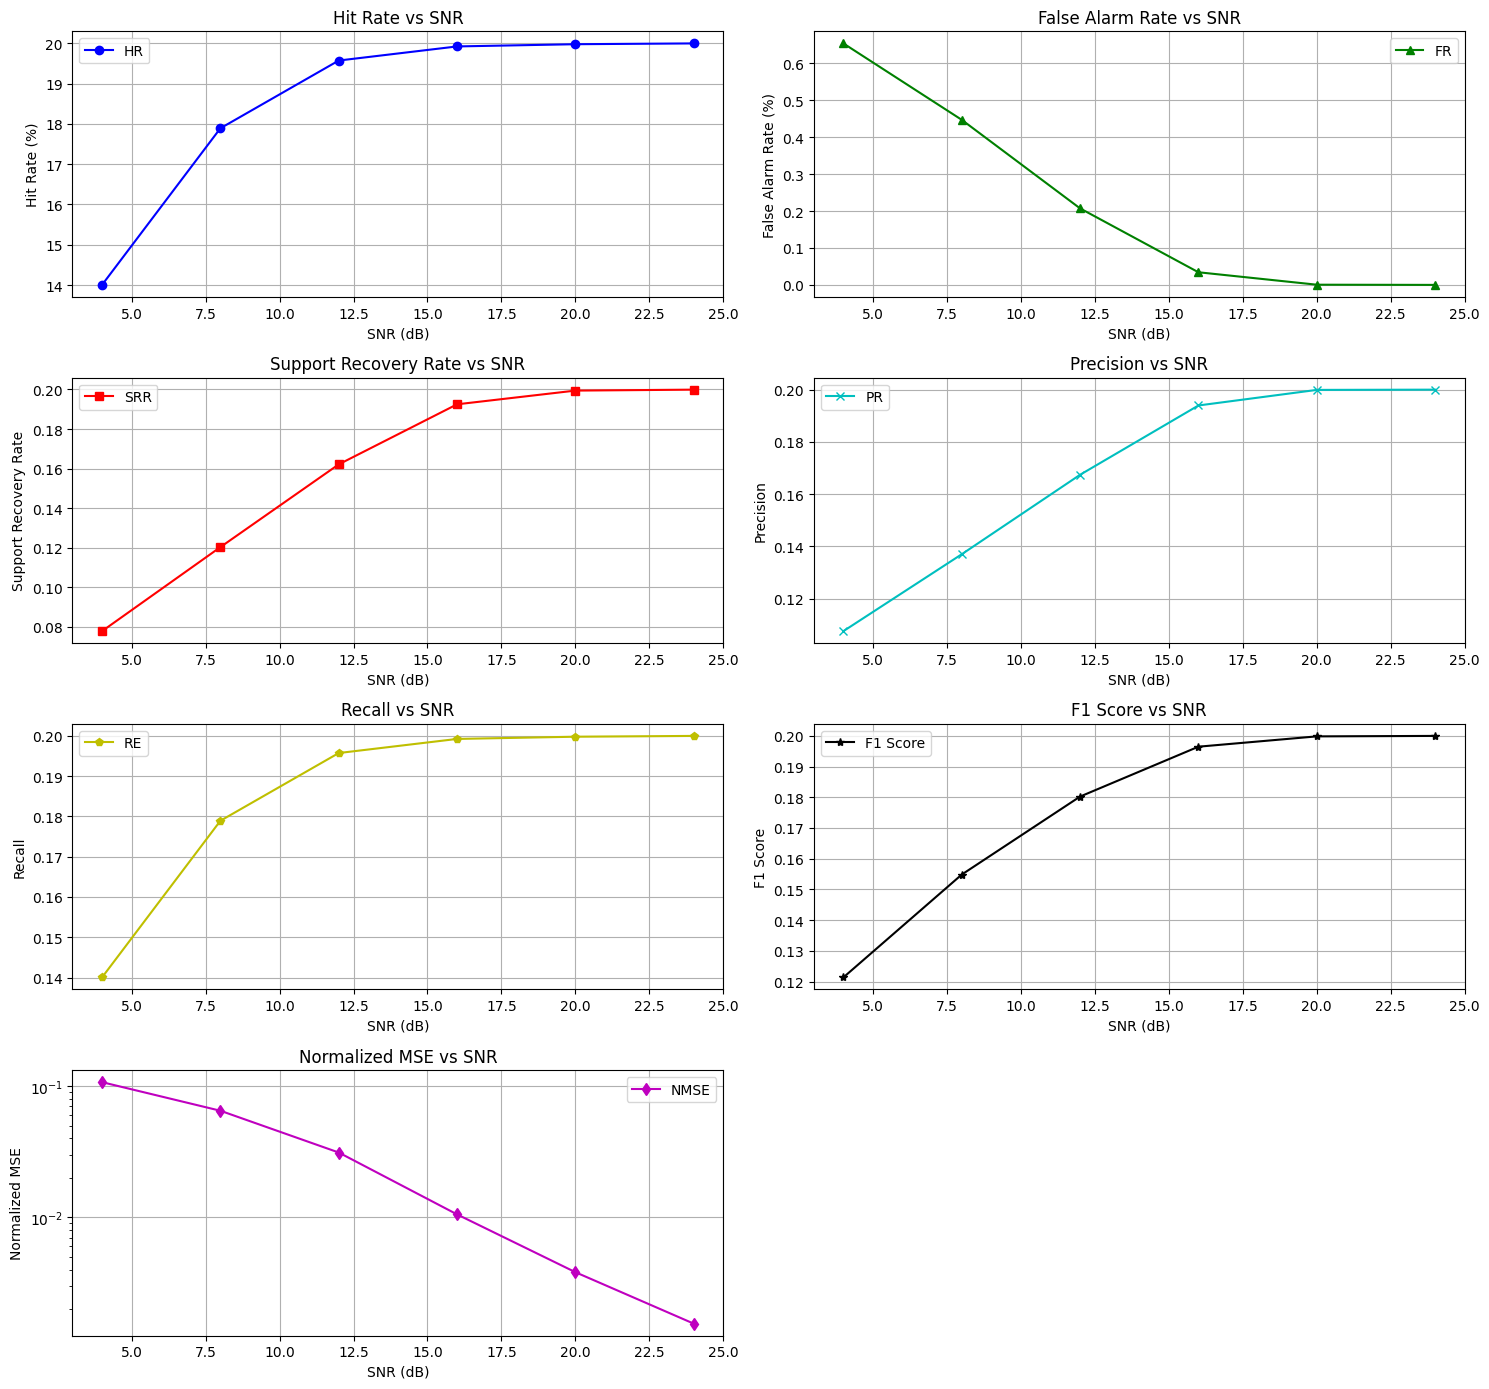

In [9]:
import matplotlib.pyplot as plt

# Define the SNR values for x-axis
snr_values = snr_db_array

# Create subplots for different performance metrics
plt.figure(figsize=(15, 14))

# Plot Hit Rate (HR)
plt.subplot(4, 2, 1)
plt.plot(snr_values, avg_hr, marker='o', linestyle='-', color='b', label='HR')
plt.xlabel("SNR (dB)")
plt.ylabel("Hit Rate (%)")
plt.title("Hit Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot False Alarm Rate (FR)
plt.subplot(4, 2, 2)
plt.plot(snr_values, avg_fr, marker='^', linestyle='-', color='g', label='FR')
plt.xlabel("SNR (dB)")
plt.ylabel("False Alarm Rate (%)")
plt.title("False Alarm Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot Support Recovery Rate (SRR)
plt.subplot(4, 2, 3)
plt.plot(snr_values, avg_srr, marker='s', linestyle='-', color='r', label='SRR')
plt.xlabel("SNR (dB)")
plt.ylabel("Support Recovery Rate")
plt.title("Support Recovery Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot Precision (PR)
plt.subplot(4, 2, 4)
plt.plot(snr_values, avg_pr, marker='x', linestyle='-', color='c', label='PR')
plt.xlabel("SNR (dB)")
plt.ylabel("Precision")
plt.title("Precision vs SNR")
plt.grid(True)
plt.legend()

# Plot Recall (RE)
plt.subplot(4, 2, 5)
plt.plot(snr_values, avg_re, marker='p', linestyle='-', color='y', label='RE')
plt.xlabel("SNR (dB)")
plt.ylabel("Recall")
plt.title("Recall vs SNR")
plt.grid(True)
plt.legend()

# Plot F1 Score (F1)
plt.subplot(4, 2, 6)
plt.plot(snr_values, avg_f1, marker='*', linestyle='-', color='k', label='F1 Score')
plt.xlabel("SNR (dB)")
plt.ylabel("F1 Score")
plt.title("F1 Score vs SNR")
plt.grid(True)
plt.legend()

# Plot Normalized MSE (NMSE)
plt.subplot(4, 2, 7)
plt.plot(snr_values, avg_nmse, marker='d', linestyle='-', color='m', label='NMSE')
plt.xlabel("SNR (dB)")
plt.ylabel("Normalized MSE")
plt.title("Normalized MSE vs SNR")
plt.yscale('log')  # Log scale for better visualization
plt.grid(True)
plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_res_vs_ground_truth(sbl_results, Z, sample_index, snr_index, snr_value):
    """Plot sbl reconstructed signal vs ground truth (Z) for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    # Ground truth (Z)
    plt.plot(np.abs(Z[sample_index,:,0]), marker='s', linestyle='--', color='g', label="Ground Truth (Z)")

    # sbl Estimated Signal
    plt.plot(np.abs(sbl_results[sample_index, snr_index, :, 0]), marker='o', linestyle='-', color='b', label="sbl Estimate")

    plt.xlabel("Device Index")
    plt.ylabel("Magnitude of Signal")
    plt.title(f"sbl vs. Ground Truth (Sample {sample_index}, SNR {snr_value} dB)")
    plt.legend()
    plt.grid(True)
    plt.show()

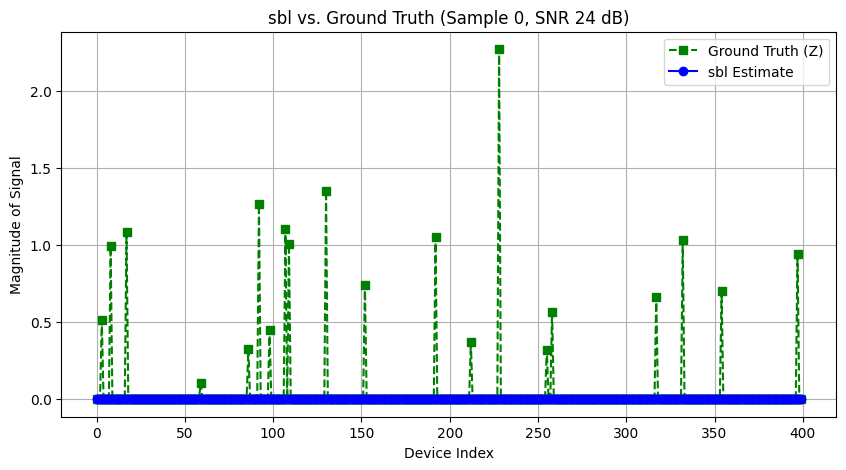

In [11]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_res_vs_ground_truth(z_res, all_z, sample_index, snr_index, snr_value)

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gamma_res_vs_ground_truth(gamma_res, gamma_true, sample_index, snr_index, snr_value):
    """Plot sbl estimated gamma vs ground truth gamma for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    device_indices = np.arange(len(gamma_true[sample_index]))  # X-axis: Device indices

    # Plot ground truth gamma (binary)
    plt.stem(device_indices, gamma_true[sample_index], linefmt='g--', markerfmt='gs', basefmt=" ", label="Ground Truth (γ)")

    # Plot sbl estimated gamma
    plt.stem(device_indices, gamma_res[sample_index, snr_index], linefmt='b-', markerfmt='bo', basefmt=" ", label="sbl Estimate (γ)")

    plt.xlabel("Device Index")
    plt.ylabel("Activity Indicator (0=Inactive, 1=Active)")
    plt.title(f"Device Activity (sbl vs. Ground Truth) - Sample {sample_index}, SNR {snr_value} dB")
    plt.legend()
    plt.grid(True)
    plt.show()


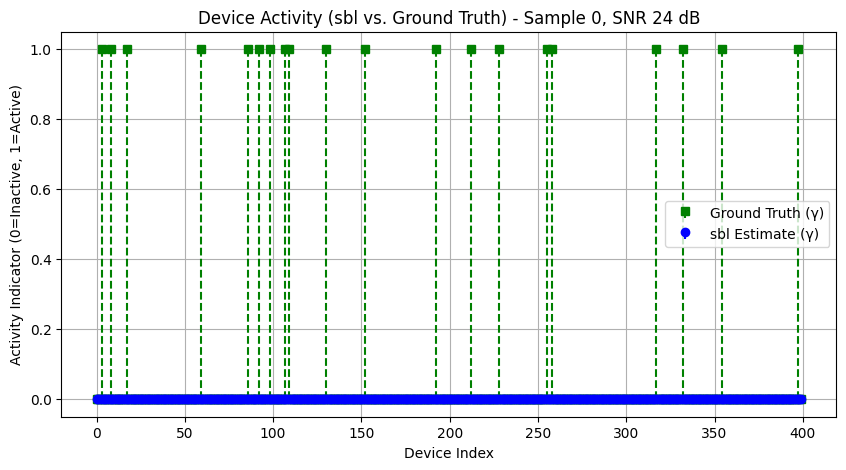

In [13]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_gamma_res_vs_ground_truth(gamma_res, all_gamma, sample_index, snr_index, snr_value)